# CS 378 Homework 3: The Science of Fairness (100 pts)

## Deadline: 11:59 pm, October 13, 2022

This assignment has three parts. In the first part, you will perform an analysis of fairness on the COMPAS dataset that you previously encountered in Assignment 1. The second and third parts consist of theoretical questions about fairness criteria and causality. 


## Part 1: Further analysis of the COMPAS dataset

### Prelude

Here is the code for loading and cleaning up the dataset.

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Data = pd.read_csv("german_credit_data.csv")
#print (Data.columns)

Data['Saving accounts'] = Data['Saving accounts'].map({"little":0,"moderate":1,"quite rich":2 ,"rich":3 });
Data['Saving accounts'] = Data['Saving accounts'].fillna(Data['Saving accounts'].dropna().mean())

Data['Checking account'] = Data['Checking account'].map({"little":0,"moderate":1,"rich":2 });
Data['Checking account'] = Data['Checking account'].fillna(Data['Checking account'].dropna().mean())

Data['Sex'] = Data['Sex'].map({"male":0,"female":1}).astype(float)

Data['Housing'] = Data['Housing'].map({"own":0,"free":1,"rent":2}).astype(float)

Data['Purpose'] = Data['Purpose'].map({'radio/TV':0, 'education':1, 'furniture/equipment':2, 'car':3, 'business':4,
       'domestic appliances':5, 'repairs':6, 'vacation/others':7}).astype(float)

Data['Risk'] = Data['Risk'].map({"good":0,"bad":1}).astype(float)
Data = Data.drop(columns=['Unnamed: 0'])
#print (Data.columns)
#Data.head(10)
#Data.drop('Unnamed: 0')
Data.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,0.0,2,0.0,0.456548,0.000000,1169,6,0.0,0.0
1,22,1.0,2,0.0,0.000000,1.000000,5951,48,0.0,1.0
2,49,0.0,1,0.0,0.000000,0.651815,2096,12,1.0,0.0
3,45,0.0,2,1.0,0.000000,0.000000,7882,42,2.0,0.0
4,53,0.0,2,1.0,0.000000,0.000000,4870,24,3.0,1.0
5,35,0.0,1,1.0,0.456548,0.651815,9055,36,1.0,0.0
6,53,0.0,2,0.0,2.000000,0.651815,2835,24,2.0,0.0
7,35,0.0,3,2.0,0.000000,1.000000,6948,36,3.0,0.0
8,61,0.0,1,0.0,3.000000,0.651815,3059,12,0.0,0.0
9,28,0.0,3,0.0,0.000000,1.000000,5234,30,3.0,1.0


And here is the code for performing a train-test split, training a logistic regression model, and computing the test accuracy.

In [141]:
X = Data.drop(columns=['Risk', "Sex"])
Y = Data['Risk']

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=137)

tempX = Data.drop(columns=["Risk"])
tempY = Data['Risk']

temptrain_x, temptest_x, temptrain_y, temptest_y = train_test_split(tempX, tempY, test_size=0.2, random_state=137)

# FEMALES ARE 0
# MALES ARE 1

test_x_male = test_x[temptest_x['Sex'] == 1]
test_y_male = test_y[temptest_x['Sex'] == 1]

test_x_female = test_x[temptest_x['Sex'] == 0]
test_y_female = test_y[temptest_x['Sex'] == 0]






In [142]:
# Getting low risk/high risk data

test_x_male_lowrisk = test_x_male[test_y_male == 0]
test_y_male_lowrisk = test_y_male[test_y_male == 0]

test_x_male_highrisk = test_x_male[test_y_male == 1]
test_y_male_highrisk = test_y_male[test_y_male == 1]

test_x_female_lowrisk = test_x_female[test_y_female == 0]
test_y_female_lowrisk = test_y_female[test_y_female == 0]

test_x_female_highrisk = test_x_female[test_y_female == 1]
test_y_female_highrisk = test_y_female[test_y_female == 1]

In [143]:
class Dataset(torch.utils.data.Dataset):
    
    # Create Torch Dataset object.
    def __init__(self, X, Y):

        #X = X.reshape((-1, 1, 64, 64))  
        #self.X = torch.from_numpy(X)
        #self.Y = torch.from_numpy(Y)
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        X = self.X[index]
        Y = self.Y[index]

        return {'X': X, 'Y': Y}

In [86]:
def train(epoch, net, trainDataLoader, optimizer, criterion, validDataLoader):
    net.train()
    train_loss = 0
    for sample in trainDataLoader:
        inputs, targets = sample['X'], sample['Y']
        #print (inputs, targets)
        optimizer.zero_grad()
        outputs = net.forward(inputs)
        #print ("outputs/targets", outputs, targets)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size

    net.eval()
    valid_loss = 0
    for sample in validDataLoader:
        inputs, targets = sample['X'], sample['Y']
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        valid_loss += loss.item() * batch_size

    # calculate average losses
    train_loss = train_loss/len(trainDataLoader.sampler)
    valid_loss = valid_loss/len(validDataLoader.sampler)

    if epoch % 1 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    return train_loss, valid_loss


In [87]:
import torch
from torch.autograd import Variable
import sklearn
import numpy as np

scaler = sklearn.preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
test_x_male = scaler.transform(test_x_male)
test_x_female = scaler.transform(test_x_female)
test_x_male_highrisk = scaler.transform(test_x_male_highrisk)
test_x_male_lowrisk = scaler.transform(test_x_male_lowrisk)
test_x_female_highrisk = scaler.transform(test_x_female_highrisk)
test_x_female_lowrisk = scaler.transform(test_x_female_lowrisk)

train_x = torch.from_numpy(train_x.astype(np.float32))
test_x = torch.from_numpy(test_x.astype(np.float32))
test_x_male = torch.from_numpy(test_x_male.astype(np.float32))
test_x_female = torch.from_numpy(test_x_female.astype(np.float32))
test_x_male_highrisk = torch.from_numpy(test_x_male_highrisk.astype(np.float32))
test_x_male_lowrisk = torch.from_numpy(test_x_male_lowrisk.astype(np.float32))
test_x_female_highrisk = torch.from_numpy(test_x_female_highrisk.astype(np.float32))
test_x_female_lowrisk = torch.from_numpy(test_x_female_lowrisk.astype(np.float32))



# Train_y is now a numpy object 
train_y = list(train_y)

# train_y is now a torch object 
train_y = torch.as_tensor(train_y, dtype = torch.float32)
test_y = torch.as_tensor(list(test_y), dtype=torch.float32)
test_y_male = torch.as_tensor(list(test_y_male), dtype=torch.float32)
test_y_female = torch.as_tensor(list(test_y_female), dtype=torch.float32)
test_y_male_highrisk = torch.as_tensor(list(test_y_male_highrisk), dtype=torch.float32)
test_y_male_lowrisk = torch.as_tensor(list(test_y_male_lowrisk), dtype=torch.float32)
test_y_female_highrisk = torch.as_tensor(list(test_y_female_highrisk), dtype=torch.float32)
test_y_female_lowrisk = torch.as_tensor(list(test_y_female_lowrisk), dtype=torch.float32)


train_y = train_y.view(train_y.shape[0],1)
test_y = test_y.view(test_y.shape[0],1)
test_y_male = test_y_male.view(test_y_male.shape[0],1)
test_y_female = test_y_female.view(test_y_female.shape[0],1)
test_y_male_highrisk = test_y_male_highrisk.view(test_y_male_highrisk.shape[0],1)
test_y_male_lowrisk = test_y_male_lowrisk.view(test_y_male_lowrisk.shape[0],1)
test_y_female_highrisk = test_y_female_highrisk.view(test_y_female_highrisk.shape[0],1)
test_y_female_lowrisk = test_y_female_lowrisk.view(test_y_female_lowrisk.shape[0],1)

n_samples,n_features=train_x.shape

In [88]:
def accuracy(model, test_x):
    model.eval()
    with torch.no_grad():
     y_pred=model(test_x)
     y_pred_class=y_pred.round()
     accuracy=(y_pred_class.eq(test_y).sum())/float(test_y.shape[0])
     print(accuracy.item())

In [129]:
# YOUR CODE HERE

import torch
from torch.autograd import Variable


class DNN_model(torch.nn.Module):
 def __init__(self,no_input_features):
    super(DNN_model,self).__init__()
    self.layer1 = torch.nn.Linear(no_input_features,20)
    self.layer2 = torch.nn.Linear(20,20)
    self.layer3 = torch.nn.Linear(20,20)
    self.layer4 = torch.nn.Linear(20,20)
    self.layer5 = torch.nn.Linear(20,1)
    
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
        
    self.seq = torch.nn.Sequential(
        self.layer1,
        self.relu,
        self.layer2,
        self.relu,
        self.layer3,
        self.relu,
        self.layer4,
        self.relu
    )

 def forward(self,x):
    # YOUR ANSWER HERE
    return self.sigmoid(self.layer5(self.seq(x)))

print(train_x.shape)
print (type(train_x))

batch_size = 1
trainSignData = Dataset(train_x, train_y)
print (len(trainSignData))
trainDataLoader = torch.utils.data.DataLoader(trainSignData, shuffle=True, batch_size=batch_size)
testSignData = Dataset(test_x, test_y)
testDataLoader = torch.utils.data.DataLoader(testSignData, shuffle=True, batch_size=batch_size)

dnnmodel = DNN_model(8)
dnnepochs = 15
dnnlr = 5e-4
criterion = torch.nn.BCELoss()
dnnoptimizer = torch.optim.Adam(dnnmodel.parameters(), lr=dnnlr, weight_decay=1e-5)
for epoch in range(dnnepochs):
    #print ("hey")
    print ("epoch", epoch)
    train(epoch, dnnmodel, trainDataLoader, dnnoptimizer, criterion, testDataLoader)

torch.save(dnnmodel, "dnnmodel.pt")

torch.Size([800, 8])
<class 'torch.Tensor'>
800
epoch 0
Epoch: 0 	Training Loss: 0.628490 	Validation Loss: 0.598933
epoch 1
Epoch: 1 	Training Loss: 0.578349 	Validation Loss: 0.579706
epoch 2
Epoch: 2 	Training Loss: 0.571467 	Validation Loss: 0.568562
epoch 3
Epoch: 3 	Training Loss: 0.564175 	Validation Loss: 0.561972
epoch 4
Epoch: 4 	Training Loss: 0.558791 	Validation Loss: 0.558737
epoch 5
Epoch: 5 	Training Loss: 0.554060 	Validation Loss: 0.559184
epoch 6
Epoch: 6 	Training Loss: 0.548167 	Validation Loss: 0.554653
epoch 7
Epoch: 7 	Training Loss: 0.544719 	Validation Loss: 0.558721
epoch 8
Epoch: 8 	Training Loss: 0.540590 	Validation Loss: 0.558920
epoch 9
Epoch: 9 	Training Loss: 0.533480 	Validation Loss: 0.564533
epoch 10
Epoch: 10 	Training Loss: 0.526598 	Validation Loss: 0.566603
epoch 11
Epoch: 11 	Training Loss: 0.520787 	Validation Loss: 0.559248
epoch 12
Epoch: 12 	Training Loss: 0.517460 	Validation Loss: 0.558509
epoch 13
Epoch: 13 	Training Loss: 0.512612 	Vali

In [130]:
accuracy(dnnmodel, test_x)

0.7250000238418579


#### Q4: Show the ROC curves for the black and white subgroups, and plot the points corresponding to the different strategies clearly identified. The resulting curve should look like the ROC curve in the FICO score case study that was discussed in class.  (5 points)

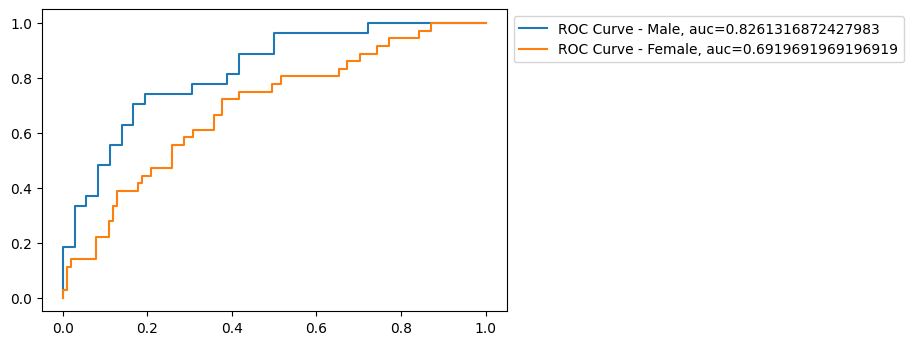

In [94]:
import matplotlib.pyplot as plt
from sklearn import metrics

from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

malePreds = dnnmodel(test_x_male).detach()
femalePreds = dnnmodel(test_x_female).detach()

fpr_m, tpr_m, thresholds_m = metrics.roc_curve(test_y_male, malePreds)
auc = metrics.roc_auc_score(test_y_male, malePreds)
plt.plot(fpr_m,tpr_m,label="ROC Curve - Male, auc="+str(auc))

fpr_f, tpr_f, thresholds_f = metrics.roc_curve(test_y_female, femalePreds)
auc = metrics.roc_auc_score(test_y_female, femalePreds)
plt.plot(fpr_f,tpr_f,label="ROC Curve - Female, auc="+str(auc))

# lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > minBlackThreshold else 0)
# lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > minWhiteThreshold else 0)


# ax.scatter(bfp/(bfp + btn), btp/(btp + bfn), c='black', marker='^', s=100, label='Max Profit Black')
# ax.scatter(wfp/(wfp + wtn), wtp/(wtp + wfn), c='green', marker='^', s= 100, label="Max Profit White")

plt.legend(loc=0, bbox_to_anchor=(1,1))

#### Q5: (i) Do a calibration plot that plots the fraction of defendants recidividating within two years as a function of the predicted probability of recidivism, for black defendants and white defendants. (ii) Comment (in a couple of sentences) if you believe that the score satisfies sufficiency across racial groups.      (5 points)

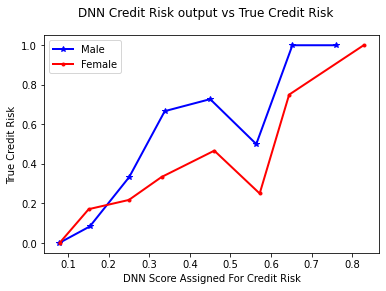

In [95]:
# YOUR CODE HERE 
from sklearn.calibration import calibration_curve
y_m, x_m = calibration_curve(
    test_y_male, 
    malePreds, 
    n_bins=10)

y_f, x_f = calibration_curve(
    test_y_female, 
    femalePreds, 
    n_bins=10)


fig, ax = plt.subplots()

plt.plot(x_m, y_m, color='blue', 
         marker='*', 
         linewidth = 2, 
         label='Male')

plt.plot(x_f, y_f, color='red', 
         marker='.', 
         linewidth = 2, 
         label='Female')

# # reference line, legends, and axis labels
ax.set_xlabel('DNN Score Assigned For Credit Risk')
ax.set_ylabel('True Credit Risk')
fig.suptitle('DNN Credit Risk output vs True Credit Risk')
plt.legend()
plt.show()



Being sufficient means $Y \perp A \mid R$.  Sufficiency doesn't hold here, as females are getting predicted to have higher credit risk even when their true credit risk isn't as high (the lines don't match up).  So, females are getting discriminated against.

#### Q6: (i) Plot the distributions of scores received by the positive class (recidivists) and the distribution of scores received by the negative class (non-recidivists) for black and white defendants. (ii) Based on these plots, comment (in a couple of sentences) if this score satisfies separation.  (5 points)

/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_25624/3404279966.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(femaleLowRiskPreds,
/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_25624/3404279966.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(maleLowRiskPreds,


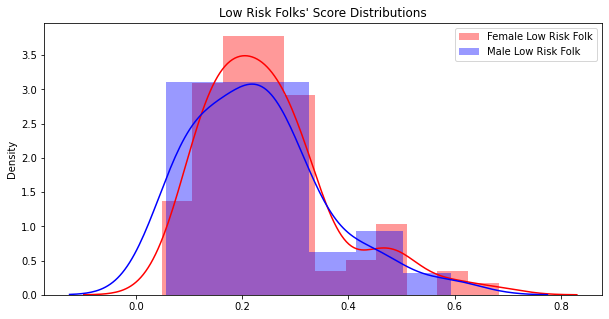

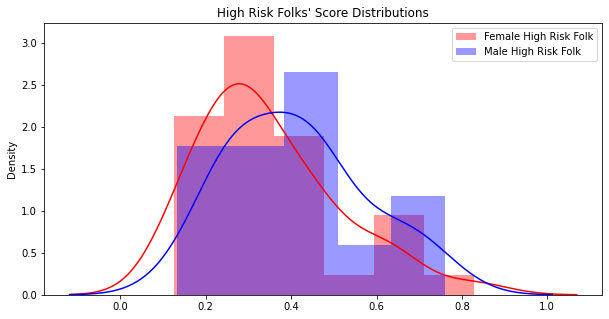

In [98]:
# YOUR CODE HERE

#print (test_y_white.head())

maleLowRiskPreds = dnnmodel(test_x_male_lowrisk).detach()
maleHighRiskPreds = dnnmodel(test_x_male_highrisk).detach()

femaleLowRiskPreds = dnnmodel(test_x_female_lowrisk).detach()
femaleHighRiskPreds = dnnmodel(test_x_female_highrisk).detach()

import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(femaleLowRiskPreds, 
             color="red", 
             label="Female Low Risk Folk").set(title = "Low Risk Folks' Score Distributions")
sns.distplot(maleLowRiskPreds, 
             color="blue", 
             label="Male Low Risk Folk").set(title = "Low Risk Folks' Score Distributions")
plt.legend()

plt.figure(figsize=(10,5))
sns.distplot(femaleHighRiskPreds, 
             color="red", 
             label="Female High Risk Folk").set(title = "High Risk Folks' Score Distributions")
sns.distplot(maleHighRiskPreds, 
             color="blue", 
             label="Male High Risk Folk").set(title = "High Risk Folks' Score Distributions")
plt.legend()




Separation means that $R \perp A \mid Y$.  So given the true label of recidivism, the logistic regression output must be independent of the race sensitive variable $A$.  This does NOT satisfy separation, because for both labels (non-recidivists and recidivists), we can see that the model outputted significantly lower scores for white people.

In [104]:
def falseaLossTrueLossSeparationHelper(model, data, labels, verbose=True):
    data = pd.DataFrame(data.numpy())
    labels = pd.DataFrame(labels.numpy())
    sexIndex = 2
    xd = data[sexIndex] < 0
    dx = (labels == 1).squeeze()

    femaleTrueData = data[(data[sexIndex] < 0) & (labels == 1).squeeze()]
    femaleFalseData = data[(data[sexIndex] < 0) & (labels == 0).squeeze()]

    maleTrueData = data[(data[sexIndex] > 0) & (labels == 1).squeeze()]
    maleFalseData = data[(data[sexIndex] > 0) & (labels == 0).squeeze()]
    
    femaleTrueData = torch.tensor(femaleTrueData.values)
    femaleFalseData = torch.tensor(femaleFalseData.values)
    
    maleTrueData = torch.tensor(maleTrueData.values)
    maleFalseData = torch.tensor(maleFalseData.values)
    
    femaleTruePreds = model(femaleTrueData)
    femaleFalsePreds = model(femaleFalseData)
    
    maleTruePreds = model(maleTrueData)
    maleFalsePreds = model(maleFalseData)
    
    femaleTruePosProb = (torch.sum(femaleTruePreds.round())/len(femaleTrueData))
    femaleFalsePosProb = (torch.sum(femaleFalsePreds.round())/len(femaleFalseData))
    
    maleTruePosProb = (torch.sum(maleTruePreds.round())/len(maleTrueData))
    maleFalsePosProb = (torch.sum(maleFalsePreds.round())/len(maleFalseData))
    
    print ("femaleTruePosProb(prob of marking a high risk female): ", femaleTruePosProb.detach())
    print ("maleTruePosProb(prob of marking a high risk male): ", maleTruePosProb.detach())

    print ("femaleFalsePosProb(prob of marking a low risk female): ", femaleFalsePosProb.detach())    
    print ("maleFalsePosProb(prob of marking a low risk male): ", maleFalsePosProb.detach())
    
    falseLoss = abs(femaleFalsePosProb - maleFalsePosProb)
    trueLoss = abs(femaleTruePosProb - maleTruePosProb)
    
    # R = model output
    # A = sex (0 = female), (1 = male)
    # Y = 0 (low risk), Y = 1 (high risk)
    
    if verbose:
        print ("|P(R = 1 | A = 1, Y = 0) - P(R = 1 | A = 0, Y = 0)| = ", falseLoss.item())
        print ("|P(R = 1 | A = 1, Y = 1) - P(R = 1 | A = 0, Y = 1)| = ", trueLoss.item())
    return falseLoss, trueLoss
    
def maxSeparation(model, data, labels):
    res = falseaLossTrueLossSeparationHelper(model, data, labels)
    return max(res[0].item(), res[1].item())
    
def separation(model, data, labels):
    maxSep = maxSeparation(model, data, labels)
    eps = 0.05
    return (maxSep < eps)

def separationLoss(model, data, labels):
    falseLoss, trueLoss = falseaLossTrueLossSeparationHelper(model, data, labels, verbose=False)
    return falseLoss + trueLoss

print ("Does the model satisfy separation: ", separation(dnnmodel, test_x, test_y))

femaleTruePosProb(prob of marking a high risk female):  tensor(0.1316)
maleTruePosProb(prob of marking a high risk male):  tensor(0.2400)
femaleFalsePosProb(prob of marking a low risk female):  tensor(0.0183)
maleFalsePosProb(prob of marking a low risk male):  tensor(0.1071)
|P(R = 1 | A = 1, Y = 0) - P(R = 1 | A = 0, Y = 0)| =  0.08879423141479492
|P(R = 1 | A = 1, Y = 1) - P(R = 1 | A = 0, Y = 1)| =  0.10842104256153107
Does the model satisfy separation:  False


In [105]:
# creating new dataset

genderX = Data.drop(columns=['Risk', 'Sex'])
genderY = Data['Sex']

gendertrain_x, gendertest_x, gendertrain_y, gendertest_y = train_test_split(genderX, genderY, test_size=0.2, random_state=137)

scaler = sklearn.preprocessing.StandardScaler()
gendertrain_x = scaler.fit_transform(gendertrain_x)
gendertest_x = scaler.transform(gendertest_x)

gendertrain_x = torch.from_numpy(gendertrain_x.astype(np.float32))
gendertest_x = torch.from_numpy(gendertest_x.astype(np.float32))

# Train_y is now a numpy object 
gendertrain_y = list(gendertrain_y)

# train_y is now a torch object 
gendertrain_y = torch.as_tensor(gendertrain_y, dtype = torch.float32)
gendertest_y = torch.as_tensor(list(gendertest_y), dtype=torch.float32)

gendertrain_y = gendertrain_y.view(gendertrain_y.shape[0],1)
gendertest_y = gendertest_y.view(gendertest_y.shape[0],1)

n_samples,n_features=gendertrain_x.shape


In [137]:
from copy import deepcopy

batch_size = 1
genderTrainData = Dataset(gendertrain_x, gendertrain_y)
genderTrainDataLoader = torch.utils.data.DataLoader(genderTrainData, shuffle=True, batch_size=batch_size)
genderTestData = Dataset(gendertest_x, gendertest_y)
genderTestDataLoader = torch.utils.data.DataLoader(genderTestData, shuffle=True, batch_size=batch_size)


'''for child in dnnmodel.seq.children():
    for param in child.parameters():
        print (param)'''

savedModel = deepcopy(dnnmodel)

class GenderDNNModel(torch.nn.Module):
    def __init__(self, savedModel):
        super(GenderDNNModel,self).__init__()
        self.seq = savedModel.seq
        
        self.genderlayer1 = torch.nn.Linear(20,20)
        self.genderlayer2 = torch.nn.Linear(20,20)
        self.genderlayer3 = torch.nn.Linear(20,1)
            
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
        self.genderseq = torch.nn.Sequential(
            self.genderlayer1,
            self.relu,
            self.genderlayer2,
            self.relu,
            self.genderlayer3,
            self.sigmoid
        )
        
        
        for child in self.seq.children():
            for param in child.parameters():
                #print (param)
                param.requires_grad = False

        self.seq.eval()
    
    def forward(self, x):
        return self.genderseq(self.seq(x))
        
genderdnnmodel = GenderDNNModel(savedModel)

genderdnnepochs = 50
genderdnnlr = 1e-5
criterion = torch.nn.BCELoss()
genderdnnoptimizer = torch.optim.Adam([param for param in genderdnnmodel.parameters() if param.requires_grad == True], lr=genderdnnlr)
for epoch in range(genderdnnepochs):
    #print ("hey")
    print ("epoch", epoch)
    train(epoch, genderdnnmodel, genderTrainDataLoader, genderdnnoptimizer, criterion, genderTestDataLoader)

accuracy(genderdnnmodel, gendertest_x)
torch.save(genderdnnmodel, "genderdnnmodel.pt")

        
    






epoch 0
Epoch: 0 	Training Loss: 0.698518 	Validation Loss: 0.696217
epoch 1
Epoch: 1 	Training Loss: 0.690398 	Validation Loss: 0.688426
epoch 2
Epoch: 2 	Training Loss: 0.682771 	Validation Loss: 0.681154
epoch 3
Epoch: 3 	Training Loss: 0.675721 	Validation Loss: 0.674254
epoch 4
Epoch: 4 	Training Loss: 0.669165 	Validation Loss: 0.668064
epoch 5
Epoch: 5 	Training Loss: 0.663276 	Validation Loss: 0.662398
epoch 6
Epoch: 6 	Training Loss: 0.657989 	Validation Loss: 0.657295
epoch 7
Epoch: 7 	Training Loss: 0.653330 	Validation Loss: 0.652924
epoch 8
Epoch: 8 	Training Loss: 0.649301 	Validation Loss: 0.649025
epoch 9
Epoch: 9 	Training Loss: 0.645846 	Validation Loss: 0.645603
epoch 10
Epoch: 10 	Training Loss: 0.642888 	Validation Loss: 0.642794
epoch 11
Epoch: 11 	Training Loss: 0.640380 	Validation Loss: 0.640304
epoch 12
Epoch: 12 	Training Loss: 0.638258 	Validation Loss: 0.638276
epoch 13
Epoch: 13 	Training Loss: 0.636441 	Validation Loss: 0.636525
epoch 14
Epoch: 14 	Traini

In [138]:
print(genderdnnmodel.forward(test_x).round())

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      